# **Get data**

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download dmitrybabko/speech-emotion-recognition-en

Dataset URL: https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en
License(s): copyright-authors
 99% 981M/987M [00:16<00:00, 148MB/s]
100% 987M/987M [00:16<00:00, 64.5MB/s]


In [ ]:
! unzip speech-emotion-recognition-en

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_AN

# *Imports*

In [112]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import librosa
import librosa.display
from IPython.display import Audio

from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from collections.abc import Iterable
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization
from keras import layers, callbacks

# Data preparation

In [12]:

crema_path = '/content/Crema/'
crema_dir_list = os.listdir(crema_path)

emotions_crema = []
paths_crema = []

for it in crema_dir_list:
    paths_crema.append(crema_path + it)

    part = it.split('_')
    if part[2] == 'SAD':
        emotions_crema.append('sad')
    elif part[2] == 'ANG':
        emotions_crema.append('angry')
    elif part[2] == 'DIS':
        emotions_crema.append('disgust')
    elif part[2] == 'FEA':
        emotions_crema.append('fear')
    elif part[2] == 'HAP':
        emotions_crema.append('happy')
    elif part[2] == 'NEU':
        emotions_crema.append('neutral')
    else:
        emotions_crema.append('Unknown')


emotions_crema_df = pd.DataFrame(emotions_crema, columns=['label'])
path_crema_df = pd.DataFrame(paths_crema, columns=['path'])
df = pd.concat([emotions_crema_df, path_crema_df], axis=1)

In [ ]:
df.head(4)

# PLOT 1

Text(0.5, 1.0, 'Label distribution')

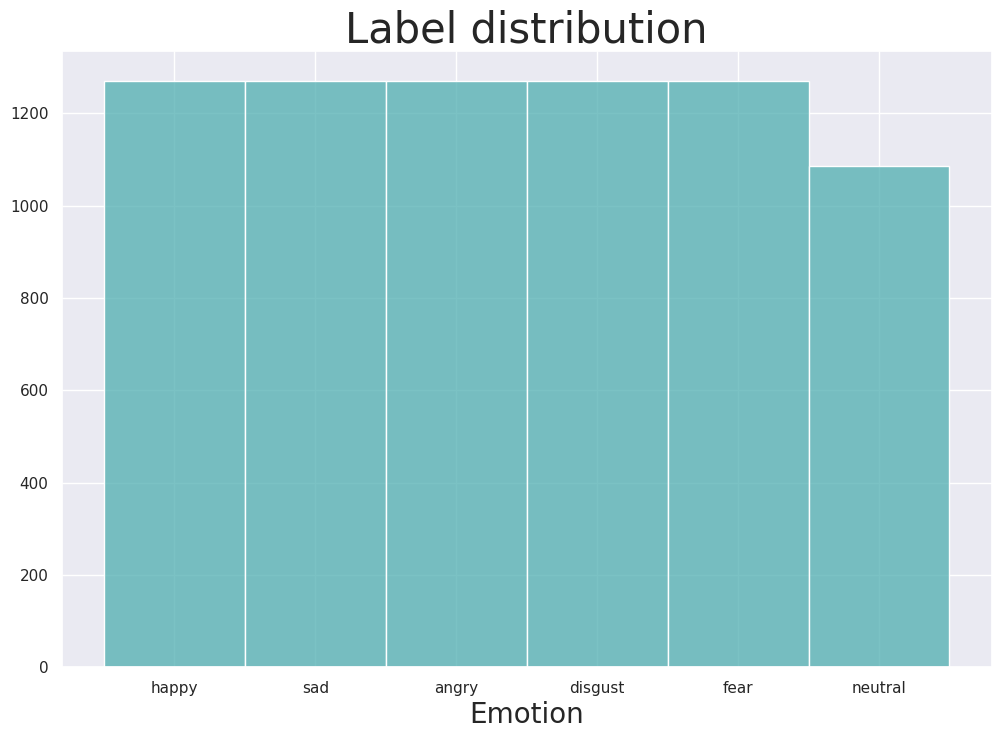

In [26]:
data_for_plot = df['label']

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('darkgrid')
sns.histplot(data_for_plot, color='#4FAEB0')
plt.xlabel('Emotion', fontsize=20)
plt.ylabel('')
plt.title('Label distribution', fontsize=30)

# PLOT 2

In [28]:
sample_rate=44100
audio_arrays = []

for i in df['path']:
    y, sr = librosa.load(i, sr=sample_rate)
    audio_arrays.append(y)

df['audio_to_array'] = audio_arrays

0       2.702698
1       1.868503
2       1.801814
3       2.135442
4       2.702698
          ...   
7437    2.335692
7438    3.737075
7439    3.536893
7440    2.836190
7441    2.802834
Name: audio_to_array, Length: 7442, dtype: float64


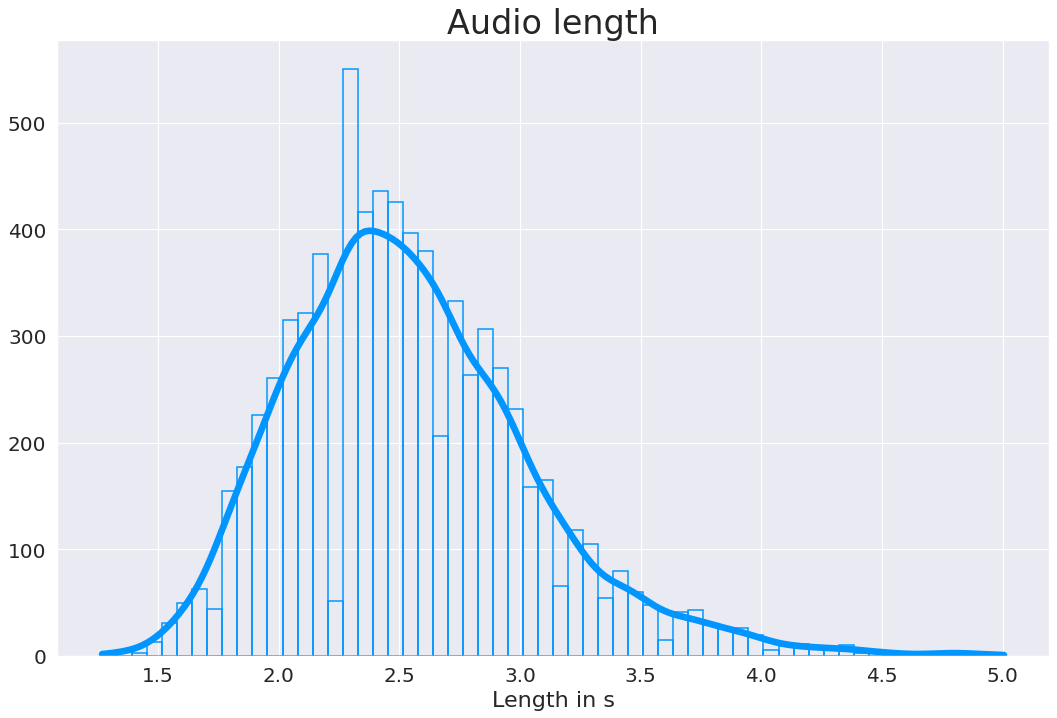

In [34]:
data_for_plot = df['audio_to_array'].apply(lambda a: len(a)/sample_rate)
print(data_for_plot)
plt.figure(figsize=(16,10), dpi= 80)
sns.histplot(data_for_plot, fill=False, bins=60, kde=True, line_kws={'lw': 6}, color='#0095ff')
plt.title("Audio length", fontsize=30, fontweight=3)
plt.ylabel('')
plt.xlabel('Length in s', fontsize=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.show()

# Preprocessing

In [100]:
frame_size = 1024
hop_lenght = 512


def amplitude_env(signal, frame_size, hop_length):
    amplitude_envelope = []
    for i in range (0, len(signal), hop_length):
        current_frame_amplitude_env = max(signal[i:i+frame_size])
        amplitude_envelope.append(current_frame_amplitude_env)

    return np.array(amplitude_envelope)


def fancy_amplitude_env (signal, frame_size, hop_length):
    return np.array([max(signal[i:i+frame_size]) for i in range(0, signal.size, hop_length)])

In [97]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40).T, axis = 0)
    return mfcc

In [98]:
x_mfcc = df['path'].apply(lambda x: extract_mfcc(x))

In [104]:
X = [x for x in x_mfcc]
X = np.expand_dims(np.array(X), -1)

enc = OneHotEncoder()
y = np.array(df['label']).reshape(-1, 1)
y = enc.fit_transform(y).toarray()

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model LSTM

## Build model

In [105]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
print(Iterable)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,734 (1.17 MB)

 Trainable params: 305,734 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

<class 'collections.abc.Iterable'>


## Train

In [122]:
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train, epochs=400, batch_size=64)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.3560 - loss: 1.5344
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.3626 - loss: 1.5563
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.3636 - loss: 1.4977
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.3835 - loss: 1.4971
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.3739 - loss: 1.4579


## Test

In [124]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

# Вывод тестовой точности
print(f'Test accuracy is {test_accuracy:.4f}')
print(f'Test loss is {test_loss:.4f}')

47/47 - 2s - 41ms/step - accuracy: 0.3667 - loss: 1.4847
Test accuracy is 0.3667
Test loss is 1.4847


# PLOT 3

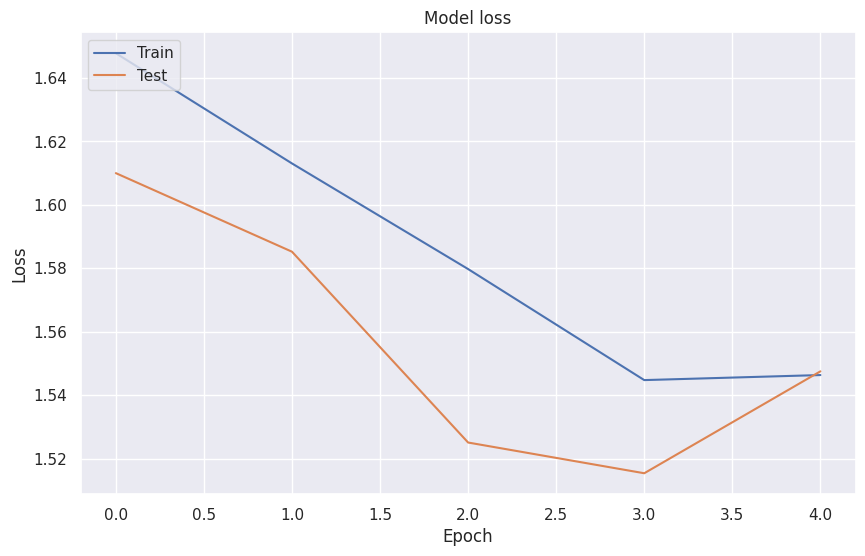

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# PLOT 4

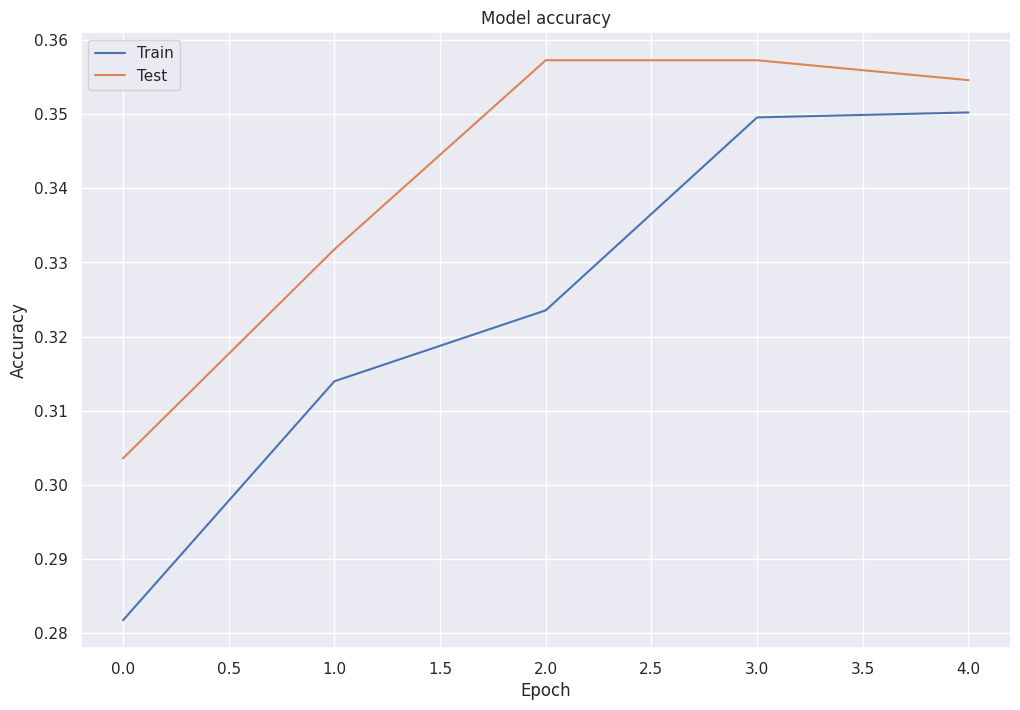

In [115]:
plt.figure(figsize=(10, 6))
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()